## Inpainting with trained Wasserstein-GAN

In [16]:
import numpy as np
import torch
import torch.nn as nn

from utils.create_data import sample_check
from utils.tools import random_bbox, mask_image
from model.networks import Generator

<Figure size 432x288 with 0 Axes>

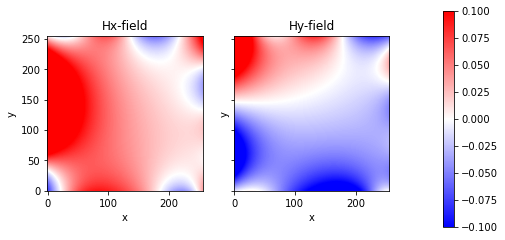

In [22]:
img_idx = 0
plt_scale = 0.1
bbox_seed = 0

cfg = {'margin_size': [10,10], 'NET_TYPE': 'wgan', 'CHAN_NUM': 32}
cfg['inpaint'] = False

if cfg['inpaint']:
    cfg['mask_size'] = [144,144]
    cfg['mask_num'] = 1
    outpaint = False
else:
    cfg['mask_size'] = [16,16]
    cfg['mask_num'] = 20
    outpaint = True

field = np.load('../data/paper_256/0.npy')
sample_check(field, v_max=plt_scale)

<Figure size 432x288 with 0 Axes>

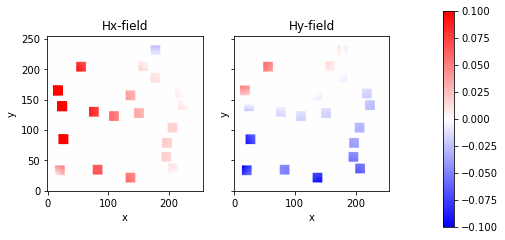

In [25]:
bboxes = random_bbox(field.shape, cfg['mask_size'], cfg['margin_size'], cfg['mask_num'], bbox_seed)
x, mask = mask_image_wgan(field, bboxes, outpaint=outpaint)
sample_check(x, v_max=plt_scale)

In [12]:
wgan_dim = field.shape[0]
if outpaint:
    if wgan_dim == 2:
        last_model_name = '../pretrained_model/wgan_2D_out_20_16/gen_best.pt'
    elif wgan_dim == 3:
        last_model_name = '../pretrained_model/wgan_3D_out_20_16/gen_best.pt'
else:
    if wgan_dim == 2:
        last_model_name = '../pretrained_model/wgan_2D_160/gen_best.pt'
    elif wgan_dim == 3:
        last_model_name = '../pretrained_model/wgan_3D_144/gen_best.pt'

netG = Generator(wgan_dim, cfg['CHAN_NUM'], True, [0])
netG.load_state_dict(torch.load(last_model_name))
netG = nn.parallel.DataParallel(netG, device_ids=[0])
corrupt_t = torch.from_numpy(x.astype('float32')).cuda().unsqueeze(0)
mask_t = torch.from_numpy(mask.astype('float32')).cuda().unsqueeze(0)

# Inference
if wgan_dim == 3:
    corrupt_t = torch.concat((corrupt_t, torch.zeros(corrupt_t[0,0].shape).cuda().unsqueeze(0).unsqueeze(0)), dim=1)
_, out, _ = netG(corrupt_t, mask_t)

<Figure size 432x288 with 0 Axes>

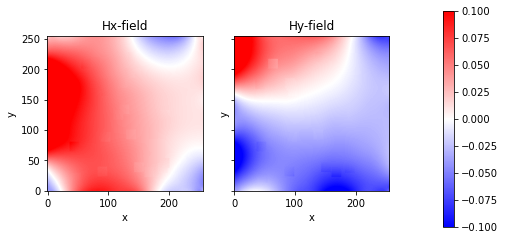

In [13]:
out_np = out.squeeze(0).cpu().data.numpy()
if wgan_dim == 3: out_np = out_np[:2]
# post_out_np = out_np / np.max(out_np)
sample_check(out_np * mask + field * (1 - mask), v_max=plt_scale, filename='wgan')

In [14]:
diff = (field - out_np) * mask
mse_final = np.mean(diff**2)
psnr = 20 * np.log10(np.max(field) / np.sqrt(mse_final))

print(f"Recon loss: {np.mean(np.abs(diff)):.9f}")
print("PSNR is: " + str(psnr) + " dB")

Recon loss: 0.008552834
PSNR is: 24.374584318954327 dB


In [15]:
out_stack = torch.from_numpy(out_np)[None, :] * mask + torch.from_numpy(field)[None, :] * (1 - mask)

# Div
Hx_x = torch.gradient(out_stack[0,0], dim=1, edge_order=2)[0]
Hy_y = torch.gradient(out_stack[0,1], dim=0, edge_order=2)[0]
if len(out_stack.size()[1:]) > 3 : 
    Hz_z = torch.gradient(out_stack[0,2], dim=2, edge_order=2)[0]
    div_mag = torch.stack([Hx_x, Hy_y, Hz_z], dim=0)[:,:,:,1]
else:
    div_mag = torch.stack([Hx_x, Hy_y], dim=0)
div = torch.mean(torch.abs(div_mag.sum(dim=0)))

#Curl
Hx_y = torch.gradient(out_stack[0,0], dim=0, edge_order=2)[0]
Hy_x = torch.gradient(out_stack[0,1], dim=1, edge_order=2)[0]
if len(out_stack.size()[1:]) > 3 :
    Hx_z = torch.gradient(out_stack[0,0], dim=2, edge_order=2)[0]
    Hy_z = torch.gradient(out_stack[0,1], dim=2, edge_order=2)[0]
    Hz_x = torch.gradient(out_stack[0,2], dim=1, edge_order=2)[0]
    Hz_y = torch.gradient(out_stack[0,2], dim=0, edge_order=2)[0]
    curl_vec = torch.stack([Hz_y - Hy_z, Hx_z - Hz_x, Hy_x - Hx_y], dim=0)[:,:,:,1]
    curl_mag = curl_vec.square().sum(dim=0)
else:
    curl_mag = (Hy_x - Hx_y).square()
curl = torch.mean(curl_mag)

print(f"divergence: {div:.12f}")
print(f"curl: {curl:.12f}")

divergence: 0.000081309868
curl: 0.000000099672
